# Chapter 15 - Natural Language Processing: Pretraining

## 15.1. Word Embedding (word2vec)

In natural language processing, words are the basic unit of the meaning. The *word vectors* are vectors used to represent words, and can also be considered as feature vectors or representations of words.

The technique of mapping words to real vectors is called *word embedding*. 

### 15.1.1. One-Hot Vectors Are a Bad Choice

Suppose that the number of different words in the dictionary (the dictionary size) is $N$, and each word corresponds to a different integer (index) from 0 to $N-1$. To obtain the one-hot vector representation for any word with index $i$, we create a length-$N$ vector with all 0s and set the element at position $i$ to 1.

However, one-hot word vectors cannot accurately express the similarity between different words, such as the *cosine similarity*. For vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$, their cosine similarity is the cosine of the angle between them:
\begin{split}
\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].
\end{split}
Since the cosine similarity between one-hot vectors of any two different words is 0, one-hot vectors cannot encode similarities among words.

### 15.1.2. Self-Supervised word2vec

The word2vec algorithm maps each word to a fixed-length vector, and thes vectors can better express the similarity and analogy relationships among different words.

The word2vec algorithm contains two models:
* *skip-gram*, and
* *continuous bag of words (CBOW)*.

Since supervision comes from the data without labels, both skip-gram and continuous bag of words are self-supervised learning models.

### 15.1.3. The Skip-Gram Model

The *skip-gram* model assumes that *a word can be used to generate its surrounding words in a text squence*.

For example, suppose a text squence, "the", "man", "loves", "his", "son". If "loves" is chosen as the *center word* and we set the context window size to 2. As shown in the figure below, given the center word "loves", the skip-gram model considers the conditional probability for generating the *context words*: "the", "man", "his", "son", which are no more than 2 words away from the center word:
\begin{split}
P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).
\end{split}

![](../imgs/ch15/skip-gram.svg)

Assume that the context words are independently generated given the center words (i.e., conditional independence). Then, the above conditional probability can be rewritten as
\begin{split}
P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}) = P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).
\end{split}

Each word in this model has two $d$-dimensional vector representations to calculate conditional probabilities.

For any word with index $i$ in the dictionary, denote by $\mathbf{v}_i \in \mathbb{R}^d$ and $\mathbf{u}_i \in \mathbb{R}^d$ its two vectors when used as a *center word* and a *context word*, respectively. The conditional probability of generating any context word $w_o$ (with index $o$ in the dictionary) given the center word $w_c$ (with index $c$ in the dictionary) can be modeled by a softmax operation on vector dot products:
\begin{split}
P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)},
\end{split}
where the vocabulary index set is $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$.

Given a text sequence of length $T$, where the word at time step $t$ is denoted by $w^{(t)}$. Assume that context words are independently generated given any center word. For context window size $m$, the likelihood function of the skip-gram model is the probability of generating all context words given any center word:
\begin{split}
\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),
\end{split}
where any time step that is less than 1 or greater than $T$ can be ignored.

#### 15.1.3.1. Training

The model parameters in the skip-gram model are the center word vectors and the context word vectors for each word in the vocabulary.

During training, we learn the model parameters by maximizing the likelihood function (i.e., maximum likelihood estimation), which is equivalent to minimizing the following loss function:
\begin{split}
- \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \textrm{log}\, P(w^{(t+j)} \mid w^{(t)}).
\end{split}

Using SGD to minimize this loss function, in each iteration, we can randomly sample a shorter subsequence to calculate the (stochastic) gradient for this subsequence to update the model parameters.

The (stochastic) gradients are the gradients of the log conditional probability with respect to the center word vector and the context word vector. Recall in the previous section that the log conditional probability involving any pair of the center word $w_c$ and the context word $w_o$ is
\begin{split}
\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)\right).
\end{split}

Its gradient with respect to the center word vector $\mathbf{v}_c$ is
\begin{split}
\begin{aligned}
\frac{\partial \textrm{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.
\end{aligned}
\end{split}
which requries the conditional probabilities of all words in the dictionary with $w_c$ as the center word.

After training, for any word with index $i$ in the dictionary, we obtain both word vectors $\mathbf{v}_i$ (as the center word) and $\mathbf{u}_i$ (as the context word).

In NLP, the center word vectors of the skip-gram model are typically used as the word representations.

### 15.1.4. The Continuous Bag of Words (CBOW) Model

The *continuous bag of words (CBOW)* model is similar to the skip-gram model. The main difference is that the CBOW model assumes that *a center word is generated based on its surrounding context words in the text sequence*.

Using the same text sequence, "the", "man", "loves", "his", "son", with "loves" as the center word and the context window size being 2, the continuous bag of words model consideres the conditional probability of generating the center word "loves" based on the context words "the", "man", "his", "son":
\begin{split}
P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).
\end{split}
as shown in the figure below.

![](../imgs/ch15/cbow.svg)

Since there are multiple context words in the CBOW model, these context word vectors are averaged in the calculation of the conditional probability.

For any word with index $i$ in the dictionary, denote by $\mathbf{v}_i \in \mathbb{R}^d$ and $\mathbf{u}_i \in \mathbb{R}^d$ its two vectors when used as a *context word* and a *center word*, respectively, (the reverse of the skip-gram model). The conditional probability of generating any center word $w_c$ (with index $c$ in the dictionary) given the context words $w_{o_1}, \ldots, w_{o_{2m}}$ (with indices $o_1, \ldots, o_{2m}$ in the dictionary) can be modeled by
\begin{split}
P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\exp\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \exp\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.
\end{split}

For brevity, let $\mathcal{W}_o = \{w_{o_1}, \ldots, w_{o_{2m}}\}$ denote the set of context words and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}\right)/(2m)$ denote their average. Then, the above conditional probability can be rewritten as
\begin{split}
P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.
\end{split}

Given a text sequence of length $T$, where the word at time step $t$ is denoted by $w^{(t)}$. For context window size $m$, the likelihood function of the CBOW model is the probability of generating all center words given any context words:
\begin{split}
\prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).
\end{split}

#### 15.1.4.1. Training

Training the CBOW model is similar to training the skip-gram model.

The maximum likelihood estimation of the CBOW model is equivalent to minimizing the following loss function:
\begin{split}
-\sum_{t=1}^T  \textrm{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).
\end{split}

Note that
\begin{split}
\log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).
\end{split}

Hence, its gradient with respect to the context word vector $\mathbf{v}_{o_i}$ ($i = 1, \ldots, 2m$) is
\begin{aligned}
\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} &= \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) \\
&= \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).
\end{aligned}

Unlike the skip-gram model, the continuous bag of words model typically uses context word vectors as the word representations.

## 15.2. Approximate Training

The gradient calculation of the skip-gram and CBOW models involves the sum of all conditional probabilities of words in the dictionary. When the dictionary is large, the sum of all conditional probabilities is computationally expensive.

To reduce the aforementioned computational cost, we can use *negative sampling* and *hierarchical softmax* to approximate the maximum likelihood estimation of the skip-gram and CBOW models.

### 15.2.1. Negative Sampling

*Negative sampling* modifies the original objective function.

Given the context window of a center word $w_c$, the fact that any (context) word $w_o$ comes from this context window is considered as an event with the probability modeled by
\begin{split}
P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c),
\end{split}
where $\sigma$ is the sigmoid function:
\begin{split}
\sigma(x) = \frac{1}{1+\exp(-x)}.
\end{split}

Given a text sequence of lenght $T$, denote by $w^{(t)}$ the word at time step $t$ and let the context window size be $m$, the joint probability of generating all context words in the text sequence is
\begin{split}
\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}).
\end{split}

This joint probability is maximized to 1 only if all the word vectors are equal to infinity. To make the objective function more meaningful, *negative sampling* adds negative examples sampled from a predefined distribution.

Denote by $S$ the event that a context word $w_o$ comes from the context window of a center word $w_c$. 

For this event involving $w_o$, from a predefined distribution $P(w)$, we can sample $K$ *noise words* that are not from this context window. Denote by $N_k$ the event that a noise word $w_k$ ($k = 1, \ldots, K$) does not come from the context window of $w_c$.

Assume that these events involving both the positive example $S$ and the negative examples $N_1, \ldots, N_K$ are mutually independent. Then, the negative sampling rewrites the joint probability (involving only positive examples $S$) as
\begin{split}
\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(D=1\mid w^{(t)}, w^{(t+j)}) = \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),
\end{split}
where the conditional probability is approximated through events $S, N_1, \ldots, N_K$:
\begin{split}
P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).
\end{split}

Denote by $i_t$ and $h_k$ the indices of a word $w^{(t)}$ at time step $t$ of a text sequence and a noise word $w_k$, respectively. The logarithmic loss with respect to the conditional probabilities of the positive example and the negative examples is
\begin{split}\begin{aligned}
-\log P(w^{(t+j)} \mid w^{(t)})
=& -\log P(D=1\mid w^{(t)}, w^{(t+j)}) - \sum_{k=1,\ w_k \sim P(w)}^K \log P(D=0\mid w^{(t)}, w_k)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\left(1-\sigma\left(\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right)\right)\\
=&-  \log\, \sigma\left(\mathbf{u}_{i_{t+j}}^\top \mathbf{v}_{i_t}\right) - \sum_{k=1,\ w_k \sim P(w)}^K \log\sigma\left(-\mathbf{u}_{h_k}^\top \mathbf{v}_{i_t}\right).
\end{aligned}\end{split}

The computational cost for gradients at each training step does not depend on the dictionary size, but linearly depends on $K$. When setting the hyperparameter $K$ to a smaller value, the computational cost for gradients at each training with negative sampling is smaller.

### 15.2.2. Hierarchical Softmax

The *hierarchical softmax* uses a binary where each leaf node of the tree represents a word in the dictionary $\mathcal{V}$, as shown in the figure below.

![](../imgs/ch15/hi-softmax.svg)

Denote by $L(w)$ the number of nodes (including both ends) on the path from the root node to the leaf node representing word $w$ in the binary tree.

Let $n(w,j)$ be the $j$-th node on this path, with its context word vector being $\mathbf{u}_{n(w,j)}$. For instance, in the figure above, $L(w_3) = 4$ since the path from the root node to the leaf node representing $w_3$ is $n(w_3, 1)$, $n(w_3, 2)$, $n(w_3, 3)$ and $w_3$.

The *hierarchical softmax* approximates the conditional probability 
\begin{split}
P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)},
\end{split}
as
\begin{split}
P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \textrm{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right),
\end{split}
where $\sigma$ is the sigmoid function and $\textrm{leftChild}(n)$ is the left child node of $n$: if $x$ is true, then $[\![x]\!] = 1$; otherwise, $[\![x]\!] = -1$.

In the figure above, if we want to calculate the conditional probaility of generating word $w_3$ given word $w_c$, we need to calculate the dot products between the word vector $\mathbf{v}_c$ of $w_c$ and non-leaf node vectors on the path (the bold line segments in the figure above) from the root to $w_3$, which is traversed left, right, and then left:
\begin{split}
P(w_3 \mid w_c) = \sigma(\mathbf{u}_{n(w_3, 1)}^\top \mathbf{v}_c) \cdot \sigma(-\mathbf{u}_{n(w_3, 2)}^\top \mathbf{v}_c) \cdot \sigma(\mathbf{u}_{n(w_3, 3)}^\top \mathbf{v}_c).
\end{split}

Since $\sigma(x) + \sigma(-x) = 1$, it holds that the conditional probabilities of generating all the words in dictionary $\mathcal{V}$ based on any word $w_c$ sum up to one:
\begin{split}
\sum_{w \in \mathcal{V}} P(w \mid w_c) = 1.
\end{split}

Since $L(w_o) - 1$ is the order of $\mathcal{O}(\log_2 |\mathcal{V}|)$ due to the binary tree structure, when the dictionary size $|\mathcal{V}|$ is large, the computational cost for each training step of the hierarchical softmax is significantly reduced compared with that without approximate training.

## 15.3. The Dataset for Pretraining Word Embeddings

In [4]:
import collections
import os
import math
import random
import torch

from d2l import torch as d2l

### 15.3.1. Reading the Dataset

The Penn Tree Bank (PTB) is a widely used dataset for language modeling. This corpus is sampled from Wall Street Journal articles. In the original format, each line of the text file represents a sentence of words that are separated by spaces. We will treat each word as a token.

In [5]:
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

In [6]:
def read_ptb():
    '''Load the PTB dataset into a list of text lines'''
    data_dir = d2l.download_extract('ptb')
    # Read the training set
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()

    return [line.split() for line in raw_text.split('\n')]

In [7]:
sentences = read_ptb()
print(f'# sentences: {len(sentences)}')

# sentences: 42069


We need to build a vocabulary for the corpus after reading the dataset. Any word that appears less than 10 times is replaced by the `<unk>` token.

In [8]:
vocab = d2l.Vocab(sentences, min_freq=10)
print(f'vocabulary size: {len(vocab)}')

vocabulary size: 6719


### 15.3.2. Subsampling

Text data typically have high-frequency words such as “the”, “a”, and “in”: they may even occur billions of times in very large corpora. However, these words often co-occur with many different words in context windows, providing little useful signals.

When training word embedding models, high-frequency words can be *subsampled*. Each indexed word $w_i$ in the dataset will be discarded with probability
\begin{split}
P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),
\end{split}
where $f(w_i)$ is the ratio of the number of words $w_i$ to the total number of words in the dataset, and the constant $t$ is a hyperparameter.

When the relative frequency $f(w_i)>t$, the word $w_i$ can be discarded. The higher the relative frequency of the word, the greater the probability of being discarded.

In [9]:
def subsample(sentences, vocab):
    '''Subsample high-frequency words'''
    # exclude unkown tokens '<unk>'
    sentences = [
        [token for token in line if vocab[token] != vocab.unk]
        for line in sentences
    ]
    counter = collections.Counter(
        [token for line in sentences for token in line]
    )

    num_tokens = sum(counter.values())

    # return True if `token` is kept during subsampling
    def keep(token):
        t = 1e-4 # threshold for subsampling
        f_w = counter[token] / num_tokens
        prob = math.sqrt(t / f_w)
        return random.uniform(0, 1) < prob
    
    return (
        [[token for token in line if keep(token)] for line in sentences],
        counter
    )

In [10]:
subsampled, counter = subsample(sentences, vocab)

We can plot the histogram of the number of tokens per sentence before and after subsampling.

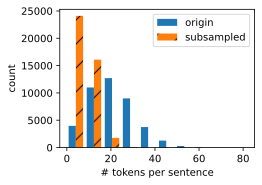

In [11]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'],
    '# tokens per sentence',
    'count',
    sentences,
    subsampled
);

In [12]:
def compare_counts(token):
    return (
        f'# of "{token}": '
        f'before={sum([l.count(token) for l in sentences])}, '
        f'after={sum([l.count(token) for l in subsampled])}'
    )

In [13]:
compare_counts('the')

'# of "the": before=50770, after=1971'

For individual tokens, the sampling rate of the high-frequency words "the" is less than 1/20.

On the other hand, low-frequency words "join" are the same.

In [14]:
compare_counts('join')

'# of "join": before=45, after=45'

After subsampling, we map tokens to their indices for the corpus:

In [15]:
corpus = [vocab[line] for line in subsampled]
corpus[0:3]

[[], [6697, 3228, 710, 1773], [3922, 1922, 4743]]

These indices correspond to

In [16]:
subsampled[0:3]

[[], ['years', 'join', 'board', 'director'], ['n.v.', 'dutch', 'publishing']]

### 15.3.3. Extracting Center Words and Context Words

The `get_centers_and_contexts` function extracts all the center words and their context words from `corpus`. It uniformly samples an integer between 1 and `max_window_size` at random as the context window size.

In [17]:
def get_centers_and_contexts(corpus, max_window_size):
    '''Return center words and context words in skip-gram'''
    centers = []
    contexts = []

    for line in corpus:
        # To form a "center word--context word" pair,
        # each sentence needs to have at least 2 words
        if len(line) < 2:
            continue

        # add line to centers
        centers += line
        for i in range(len(line)): # context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(range(
                max(0, i - window_size), # left limit
                min(len(line), i + 1 + window_size), # right limit
            ))
            # exclude the center word from the context words
            indices.remove(i)
            # add remaining words to contexts
            contexts.append([line[idx] for idx in indices])

    return centers, contexts

Now we can create an artificial dataset containing two sentences of 7 and 3 words, respectively. Let the maximum context window size be 2 nad print out all the center words and their context words.

In [17]:
tiny_dataset = [
    list(range(7)), # a sentence with 7 tokens
    list(range(7, 10)) # another sentence with 3 tokens
]
max_window_size = 2

print('dataset: ', tiny_dataset)
centers, contexts = get_centers_and_contexts(tiny_dataset, max_window_size)
for center, context in zip(centers, contexts):
    print('center', center, 'has contexts', context)

dataset:  [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [1, 3]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [3, 5]
center 5 has contexts [4, 6]
center 6 has contexts [4, 5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [8]


There is randomness in the sampling of context windows. Hence, the output of the following code may vary.

When training on the PTB dataset, we set the maximum context window size to 5.

In [19]:
max_window_size = 5
all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
print(f'# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}')

# center-context pairs: 1500707


### 15.3.4. Negative Sampling

We will use negative sampling for approximate training.

To sample noise words according to a predefined distribution, we define the `RandomGenerator` class, where the (possibly unnormalized) sampling distribution is passed via the argument `sampling_weights`.

In [18]:
class RandomGenerator:
    '''Randomly draw among {1,..., n} according to n sampling weights'''
    def __init__(self, sampling_weights):
        # exclude 0 for convenience
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # cache `k` random sampling results
            self.candidates = random.choices(
                self.population,
                self.sampling_weights,
                k=10000
            )
            self.i = 0
        
        self.i += 1
        return self.candidates[self.i - 1]

We can draw 10 random variables $X$ among indices 1, 2, and 3 with sampling probability
\begin{split}
P(X=1)=2/9, P(X=2)=3/9, \textrm{and } P(X=3)=4/9.
\end{split}

In [21]:
sampling_weights = [2, 3, 4] # 3 tokens with weights 2, 3 and 4
generator = RandomGenerator(sampling_weights)
[generator.draw() for _ in range(10)]

[2, 1, 3, 3, 2, 3, 3, 2, 3, 1]

For a pair of center word and context word, we randomly sample `K` (5 in the experiment) noise words. In the word2vec paper, the sampling probability $P(w)$ of a noise word $w$ is set to its relatie frequency in the dictionary raised to the power of 0.75.

In [19]:
def get_negatives(all_contexts, vocab, counter, K):
    '''Return noise words in negative sampling'''
    # Sampling weights for words with indices 1, 2, ...
    # (index 0 is the excluded unknown token) in the vocabulary
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75 for i in range(1, len(vocab))]

    all_negatives = []
    generator = RandomGenerator(sampling_weights)

    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)

        all_negatives.append(negatives)

    return all_negatives

In [23]:
all_negatives = get_negatives(all_contexts, vocab, counter, 5)

### 15.3.5. Loading Training Examples in Minibatches

After all the center words together with their context words and sampled noise words are extracted, they will be transformed into minibatches of examples that can be iteratively loaded during training.

In a minibatch, the $i$-th example includes a center word and its $n_i$ context words and $m_i$ noise words. Due to varying context window sizes, $n_i + m_i$ varies for different $i$. Thus, for each example in a minibatch, we concatenate its context words and noise words in the `contexts_negatives` variable, and padd zeros until the concatenation length reaches the maximum context window size $\max_i n_i + m_i$ (`max_len`) in the minibatch.

To exclude paddings in the calculation of the loss, we define a mask variable `masks`. There is a one-to-one correspondence between elements in `masks` and elements in `contexts_negatives`, where zeros (otherwise ones) in `masks` correspond to paddings (otherwise non-paddings) in `contexts_negatives`.

To distinguish between positive and negative examples in `contexts_negatives`, we separte context words from noise words via a `labels` variable. Similar to `masks`, there is also a one-to-one correspondence between elements in `labels` and elements in `contexts_negatives`, where ones (otherwise zeros) in `labels` correspond to context words (positive examples) in `contexts_negatives`.

In the `batchify` function below, its input `data` is a list with length equal to the batch size, where each element is an example consisting of the center word `center`, its context words `context`, and its noise words `negatives`. This function returns a minibatch that can be loaded for calcualtions during training.

In [20]:
def batchify(data):
    '''Return a minibatch of examples for skip-gram with negative sampling'''
    # data: (batch size, centers, contexts, negatives)
    max_len = max(len(c) + len(n) for _, c, n in data)
    # minibatch of center words
    centers = []
    # minibatch of context words and noise words associated with the center word
    contexts_negatives = []
    # mask for non-padding entries
    masks = []
    # mask for context words and noise words
    labels = []

    for center, context, negative in data:
        # take one example
        cur_len = len(context) + len(negative)
        # add center word
        centers += [center]
        # add context words, noise words, and padding associated with the center word
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        # add mask for padding
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        # add mask for context words
        labels += [[1] * len(context) + [0] * (max_len - len(context))]

    return (
        torch.tensor(centers).reshape((-1, 1)), # (batch size, 1) for center words
        torch.tensor(contexts_negatives), # (batch size, max_len) for context words and noise words
        torch.tensor(masks), # (batch size, max_len) for mask
        torch.tensor(labels) # (batch size, max_len) for mask
    )

In [26]:
# test a minibatch of three examples
X1 = (1, # center word
      [2, 2], # context words
      [3, 3, 3, 3]) # noise words
X2 = (4, # center word
      [2, 2, 2], # context words
      [3, 3]) # noise words
X3 = (1, # center word
      [3, 3, 3, 1], # context words
      [4, 4, 2, 2]) # noise words

examples = [X1, X2, X3]
batch = batchify(examples)

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [4],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3, 0, 0],
        [2, 2, 2, 3, 3, 0, 0, 0],
        [3, 3, 3, 1, 4, 4, 2, 2]])
masks = tensor([[1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])
labels = tensor([[1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0]])


### 15.3.6. Putting It All Together

In [22]:
# create a dataset class
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        # centers, contexts, and negatives are of equal length
        assert len(centers) == len(contexts) == len(negatives)

        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (
            self.centers[index], # center word
            self.contexts[index], # positive context words
            self.negatives[index], # negative noise words
        )
    
    def __len__(self):
        return len(self.centers)
    
    
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    '''Download the PTB dataset and then load it into memory'''
    num_workers = d2l.get_dataloader_workers()

    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)

    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)
        
    # intialize a dataset instance
    dataset = PTBDataset(all_centers, all_contexts, all_negatives)
    # create a dataloader
    data_iter = torch.utils.data.DataLoader(
        dataset,
        batch_size,
        shuffle=True,
        collate_fn=batchify, # use batchify function to collate examples
        num_workers=num_workers
    )

    return data_iter, vocab

In [23]:
batch_size = 512
max_window_size = 5
num_noise_words = 5

data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

In [40]:
# check the first minibatch
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

## 15.4. Pretraining word2vec

We will implement the skip-gram model and then pretrain word2vec using negative sampling on the PTB dataset.

In [24]:
import math
import torch
from torch import nn

from d2l import torch as d2l

First of all, we need to obtain the data iterator and the vocabulary of the PTB dataset.

In [25]:
batch_size = 512
max_window_size = 5
num_noise_words = 5

data_iter, vocab = load_data_ptb(batch_size, max_window_size, num_noise_words)

### 15.4.1. The Skip-Gram Model

#### 15.4.1.1. Embedding Layer

Recall from Chapter 10 that an embedding layer maps a token's index to its feature vector.

The weight of this layer is a matrix whose number of rows equals to the dictionary size (`input_dim`) and the number of columns equals to the vector dimension for each token (`output_dim`). After a word embedding model is trained, the weight of the embedding layer is what we want.

In [26]:
input_dim = 20 # vocabulary size
output_dim = 4 # vector dimension

embed = nn.Embedding(num_embeddings=input_dim,
                     embedding_dim=output_dim)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      f'dtype={embed.weight.dtype})')

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


The input of an embedding layer is the index of a token (word).

For any token index $i$, its vector representation can be obtained from the $i$-th row of the weight matrix in the embedding layer. Since the vector dimension (`output_dim`) is set to 4, the embedding layer returns vectors with shape (2, 3, 4) for a minibatch of 2 examples, each consisting of 3 tokens.

In [27]:
X = torch.tensor(
    [[1, 2, 3],
     [4, 5, 6]],
)

embed(X), embed(X).shape

(tensor([[[-0.4735, -1.2734,  1.3280,  1.4527],
          [ 0.1065, -0.8098, -1.5031,  0.3291],
          [ 0.4750, -0.7327, -0.5792,  0.3721]],
 
         [[ 1.2788, -0.3188, -1.5614,  0.7817],
          [-1.6512, -1.8211,  1.2905, -0.8847],
          [-1.5387,  1.2123, -1.1465, -0.9661]]], grad_fn=<EmbeddingBackward0>),
 torch.Size([2, 3, 4]))

#### 15.4.1.2. Defining the Forward Propagation

In the forward propagation, the input of the skip-gram model includes 
* the center word indices `center` of shape (batch size, 1), and
* the concatenated context and noise word indices `contexts_and_negatives` of shape (batch size, `max_len`).

These two variables are transformed from the token indices into vectors via the embedding layer, and then their batch matrix multiplication returns an output of shape (batch size, 1, `max_len`), where each element is the dot product of a center word vector and a context or noise word vector.

In [28]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    '''Compute the skip-gram objective function for one center word'''
    v = embed_v(center) # center word vector
    u = embed_u(contexts_and_negatives) # context and noise word vectors
    pred = torch.bmm(v, u.permute(0, 2, 1)) # bmm: batch matrix multiplication
    return pred

In [29]:
skip_gram(
    center=torch.ones((2, 1), dtype=torch.long), # batch size: 2
    contexts_and_negatives=torch.ones((2, 4), dtype=torch.long), # 4 combined context and noise words
    embed_v=embed, # embedding for center words
    embed_u=embed # embedding for context and noise words
).shape

torch.Size([2, 1, 4])

### 15.4.2. Training

#### 15.4.2.1. Binary Cross-Entropy Loss

We will use the binary cross-entropy loss to train the skip-gram model with negative sampling.

In [30]:
class SigmoidBCELoss(nn.Module):
    '''Binary cross-entropy loss with masking'''
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction='none'
        )
        return out.mean(dim=1)
    
loss = SigmoidBCELoss()

Recall that
* `mask` is a variable for excluding paddings in the loss calculation, and
* `label` is a variable for distinguishing between context words and noise words.

We can calculate the binary cross-entorpy loss for the given variables:

In [31]:
pred = torch.tensor(
    [[1.1, -2.2, 3.3, -4.4]] * 2
)

mask = torch.tensor(
    [[1, 1, 1, 1],
     [1, 1, 0, 0]]
)

label = torch.tensor(
    [[1., 0., 0., 0.],
     [0., 1., 0., 0.]]
)

loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

We can also use the sigmoid function in the binary cross-entropy loss to calculate the above results. We can consider the two outputs as two normalized losses that are average over non-masked predictions.

In [32]:
def sigmoid(x):
    return -math.log(1 / (1 + math.exp(-x)))

print(f'{(sigmoid(1.1) + sigmoid(2.2) + sigmoid(-3.3) + sigmoid(4.4)) / 4:.4f}')
print(f'{(sigmoid(-1.1) + sigmoid(-2.2)) / 2:.4f}')

0.9352
1.8462


#### 15.4.2.2. Initializing Model Parameters

We need two embedding layers for all the words in the vocabulary: one for the center words and the other for the context words and noise words.

In [33]:
embed_size = 100

net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab),
                 embedding_dim=embed_size), # embedding for center words
    nn.Embedding(num_embeddings=len(vocab),
                    embedding_dim=embed_size) # embedding for context words
)

#### 15.4.2.3. Defning the Training Loop

In [34]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    # initialize embedding parameters
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    # create an animator
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    
    # sum of normalized loss, number of normalized losses
    metric = d2l.Accumulator(2) # loss_sum, num_examples

    for epoch in range(num_epochs):
        timer = d2l.Timer()
        num_batches = len(data_iter)

        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            # center words, context+noise words, masks, labels
            center, context_negative, mask, label = [
                data.to(device) for data in batch
            ]

            # forward pass
            pred = skip_gram(center,
                             context_negative,
                             embed_v=net[0],
                             embed_u=net[1])
            # compute loss
            l = (loss(pred.reshape(label.shape).float(),
                      label.float(),
                      mask)
                      / mask.sum(axis=1) * mask.shape[1])
            
            # backward pass
            l.sum().backward()
            # update parameters
            optimizer.step()
            # update metric
            metric.add(l.sum(), l.numel())

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

Train a skip-gram model using negative sampling:

In [35]:
lr = 0.002
num_epochs = 5

train(net, data_iter, lr, num_epochs)

### 15.4.3. Applying Word Embeddings

After training the word2vec model, we can use the cosine similarity of word vectors from the trained model to find words from the dictionary that are most semantically similar to an input word.

In [ ]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]

    # compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k+1)[1].cpu().numpy().astype('int32')

    for i in topk[1:]: # remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}')

In [ ]:
get_similar_tokens('chip', 3, net[0])

## 15.5. Word Embedding with Global Vectors (GloVe)

Word-word co-occurrences within context windows may carry rich semantic information. For example, in a large corpus word “solid” is more likely to co-occur with “ice” than “steam”, but word “gas” probably co-occurs with “steam” more frequently than “ice”.

The global corpus statistics of such co-occurrences can be pre-computed.

### 15.5.1. Skip-Gram with Global Corpus Statistics

Denoting by $q_{ij}$ the conditional probability $P(w_j \mid w_i)$ of word $w_j$ given word $w_i$ in the skip-gram model, we have
\begin{split}
P(w_j \mid w_i) = q_{ij}=\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_i)}{ \sum_{k \in \mathcal{V}} \exp(\mathbf{u}_k^\top \mathbf{v}_i)},
\end{split}
where for any index $i$, vectors $\mathbf{v}_i$ and $\mathbf{u}_i$ represent word $w_i$ as the center word and the context word, respectively, and $\mathcal{V}={0, 1, \ldots, |\mathcal{V}|-1}$ is the index set of the vocabulary.

Consider the word $w_i$ that may occur multiple times in the corpus. In the entire corpus, all the context words wherever $w_i$ is taken as their center word form a *multiset* $\mathcal{C}_i$ of word indcies that *allows for multiple instances of the same element*.

For any element, its number of instances is called its *multiplicity*.

For example, suppose that the word $w_i$ occurs twice in the corpus and indices of the context words that take $w_i$ as their center word in the two context windows are $k, j, m, k$ and $k, l, k, j$. Therefore, the multiset $\mathcal{C}_i$ of word indices is $\mathcal{C}_i = \{j, j, k, k, k, k, l, m\}$, where the multiplicity of elements $j, k, l, m$ are 2, 4, 1, and 1, respectively.

Suppose that the multiplicity of element $j$ in this multiset $\mathcal{C}_i$ is denoted as $x_{ij}$, this is the global co-occurrence count of word $w_j$ (as the context word) and word $w_i$ (as the center word) in the same context window in the entire corpus.

Using such global corpus statistics, the loss function of the skip-gram model is rewritten as
\begin{split}
-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij}.
\end{split}

Suppose that the number of all the context words is denoted as $x_i$ in the context windows where $w_i$ occurs as their center word, which is equivalent to the sum of the multiplicities of all the elements in the multiset $\mathcal{C}_i$, i.e., $x_i = | \mathcal{C}_i |$. Let $p_{ij}$ be the conditional probability $x_{ij}/x_i$ for generating context word $w_j$ given center word $w_i$, then the loss function of the skip-gram model can be further rewritten as
\begin{split}
-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij} =-\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.
\end{split}

We can see that $-\sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}$ calculates the cross-entorpy of the conditional distribution $p_{ij}$ of global corpus statistics and the conditional distribution $q_{ij}$ of the model predictions. This loss is also weighted by $x_i$. Minimizing this loss function will allow the predicted conditional distribution to get close to the conditional distribution from the global corpus statistics.

### 15.5.2. The GloVe Model

The *global vectors for word representation (GloVe)* model makes 3 changes to the skip-gram model based on squared loss:
1. Use variables $p'_{ij}=x_{ij}$ and $q'_{ij}=\exp(\mathbf{u}_j^\top \mathbf{v}_i)$ that are not probability distributions and take the logarithm of both, so the squared loss term is
\begin{split}
\left(\log\,p'_{ij} - \log\,q'_{ij}\right)^2 = \left(\mathbf{u}_j^\top \mathbf{v}_i - \log\,x_{ij}\right)^2.
\end{split}
2. Add two scalar model parameters for each word $w_i$:
    * the center word bias $b_i$, and
    * the context word bias $c_i$.
3. Replace the weight of each loss term with the weight function $h(x_{ij})$, where $h(x)$ is increasing in the interval of [0, 1].

Putting all things together, training GloVe is to minimize the following loss function:
\begin{split}
\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.
\end{split}

For the weight function $h(x)$, a sugguested choice is
\begin{split}
h(x) = (x/c) ^\alpha \textrm{ if } x < c \textrm{ else } 1,
\end{split}
where $\alpha = 0.75$ and $c = 100$.

In this case, since $h(0)=0$, the squared loss term for any $x_{ij}=0$ can be omitted for computational efficiency. When using minibatch SGD, at each iteration we randomly sample a minibatch of *non-zero* $x_{ij}$ to calculate gradients and update the model parameters. These non-zero $x_{ij}$ are precomputed global corpus statistics; thus, the model is called GloVe for *Global Vectors*.

If word $w_i$ appears in the context window of word $w_i$, then *vice versa*. Therefore, $x_{ij}=x_{ji}$. Unlike word2vec that fits the asymmetric condtional probability $p_{ij}$, GloVe fits the symmetric $\log x_{ij}$. Therefore, the center word vector and the context word vector of any word are mathematically equivalent in the GloVe model.

### 15.5.3. Interpreting GloVe from the Ratio of Co-occurrence Probabilities

Let $p_{ij} \stackrel{\textrm{def}}{=} P(w_j \mid w_i)$ be the conditional probability of generating context word $w_j$ given $w_i$ as the center word in the corpus.

The table bellow lists several co-occurrence probabilities given words "ice" and "steam" and their ratios based on statistics from a large corpus.

|          | $w_k$ = "solid" | $w_k$ = "gas" | $w_k$ = "water" | $w_k$ = "fashion" |
|:--------:|:---------------:|:-------------:|:---------------:|:-----------------:|
| $p_1=P(w_k \mid \textrm{"ice"})$ | 0.00019 | 0.000066 | 0.003 | 0.000017         |
| $p_2=P(w_k \mid \textrm{"steam"})$ | 0.000022 | 0.00078 | 0.0022 | 0.000018      |
| $p_1/p_2$ | 8.9 | 0.085 | 1.36 | 0.96 |

Using this table as an example, we can see that
* For a word $w_k$ that is related to "ice" but unrelated to "steam", such as $w_k$ = "solid", we expect a larger ratio of co-occurrence probabilities $p_1/p_2 = 8.9$.
* For a word $w_k$ that is lreated to "steam" but unrelated to "ice", such as $w_k$ = "gas", we expect a smaller ratio of co-occurrence probabilities $p_1/p_2 = 0.085$.
* For a word $w_k$ that is related to both "ice" and "steam", such as $w_k$ = "water", we expect a ratio of co-occurrence probabilities $p_1/p_2 = 1.36$ that is close to 1.
* For a word $w_k$ that is unrelated to both "ice" and "steam", such as $w_k$ = "fashion", we expect a ratio of co-occurrence probabilities $p_1/p_2 = 0.96$ that is close to 1.

*The ratio of co-occurrence probabilities can intuitively express the relationship between words.* Thus, for the ratio of co-occurrence probabilities $p_{ij}/p_{ik}$, with $w_i$ being the center word and $w_j$ and $w_k$ being the context words, we want to fit this ratio using some function $f$:
\begin{split}
f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) \approx \frac{p_{ij}}{p_{ik}}.
\end{split}

Since the ratio of co-occurrence probabilities is a scalar, we require that $f$ be a scalar function, such as $f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = f\left((\mathbf{u}_j - \mathbf{u}_k)^\top {\mathbf{v}}_i\right)$. Switching word indices $j$ and $k$, it must hold that $f(x)f(-x)=1$, so one possible solution is $f(x)=\exp(x)$, i.e.,
\begin{split}
f(\mathbf{u}_j, \mathbf{u}_k, {\mathbf{v}}_i) = \frac{\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right)}{\exp\left(\mathbf{u}_k^\top {\mathbf{v}}_i\right)} \approx \frac{p_{ij}}{p_{ik}}.
\end{split}

If we pick $\exp\left(\mathbf{u}_j^\top {\mathbf{v}}_i\right) \approx \alpha p_{ij}$, where $\alpha$ is a constant, then since $p_{ij}=x_{ij}/x_i$, after taking the logarithm on both sides, we get
\begin{split}
\mathbf{u}_j^\top {\mathbf{v}}_i \approx \log\,\alpha + \log\,x_{ij} - \log\,x_i
\end{split}

We may use additional bias terms to fit $- \log\, \alpha + \log\, x_i$, such as the center word bias $b_i$ and the context word bias $c_j$:
\begin{split}
\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j \approx \log\, x_{ij}.
\end{split}

Measuring the squared error of the above approximation with weights, the GloVe loss function is obtained as before:
\begin{split}
\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} h(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2.
\end{split}

## 15.6. Subword Embedding